<a href="https://colab.research.google.com/github/prachipancholi1/SKin-Lesion-Detection-phd/blob/main/DermNet_Image_ClassssificationML_90_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Table of contents**<a id='toc0_'></a>    
- [Import Libraries](#toc1_1_1_)    
- [Defined Canny Edge Detector Class](#toc1_1_2_)    
- [Load Images](#toc1_1_3_)    
- [Train-Test Split](#toc1_1_4_)    
- [Model Training](#toc1_1_5_)    
- [Model Evaluation](#toc1_1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -a '/content/drive/MyDrive/Prachi/' '/content/'

In [ ]:
import zipfile
import os
# loading and extracting data
os.makedirs("/content/data/", exist_ok=True)

zip_ref = zipfile.ZipFile("/content/Prachi/Train.zip", 'r')
zip_ref.extractall("/content/data/")
zip_ref.close()

### <a id='toc1_1_1_'></a>[Import Libraries](#toc0_)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
from Prachi.Features.features import CannyFilter
from tqdm.notebook import tqdm
from sklearn.utils import Bunch

### <a id='toc1_1_2_'></a>[Defined Canny Edge Detector Class](#toc0_)

In [ ]:
# Defined the Canny Edge Detector class
cannyFilter = CannyFilter()

### <a id='toc1_1_3_'></a>[Load Images](#toc0_)

In [ ]:
def loadImages(container_path, dimension=(230, 230)):
    """
    Load image files with categories as subfolder names
    which performs like scikit-learn sample dataset

    Parameters
    ----------
    container_path : string or unicode
        Path to the main folder holding one sub folder per category
    dimension : tuple
        size to which image are adjusted to

    Returns
    -------
    Bunch
    """
    image_dir = Path(container_path) # Train folder path
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()] # List of subfolders
    categories = [fo.name for fo in folders] # List of subfolder name


    descr = "Dermnet Three category dataset"

    images = []
    flat_data = []
    target = []

    for i, direc in enumerate(folders):
        print(f"Folder : {direc}")
        for file in tqdm(direc.iterdir()): # Iterating each file within the folder
            img = cv2.imread(file.__str__()) # read the image and CONVERT INTO NUMPYARRAy
            img_resized = cv2.resize(img, dimension) # resize aac. to dimensions
            fimg = cannyFilter.Canny(img_resized) # applying canny filter to extract the features like edges..
            flat_data.append(fimg.flatten()) #   flattening the image in 1D
            images.append(img_resized) #
            target.append(i)
        print(f"Folder : {direc} Reading Completed ✅")

    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)

    return Bunch(data=flat_data,
                 target=target,
                 target_names=categories,
                 images=images,
                 DESCR=descr)

In [ ]:
image_dataset = loadImages(r"/content/data/Train")

Folder : /content/data/Train/Psoriasis


0it [00:00, ?it/s]

Folder : /content/data/Train/Psoriasis Reading Completed ✅
Folder : /content/data/Train/Eczema


0it [00:00, ?it/s]

Folder : /content/data/Train/Eczema Reading Completed ✅
Folder : /content/data/Train/Seborrheic_Keratoses


0it [00:00, ?it/s]

Folder : /content/data/Train/Seborrheic_Keratoses Reading Completed ✅


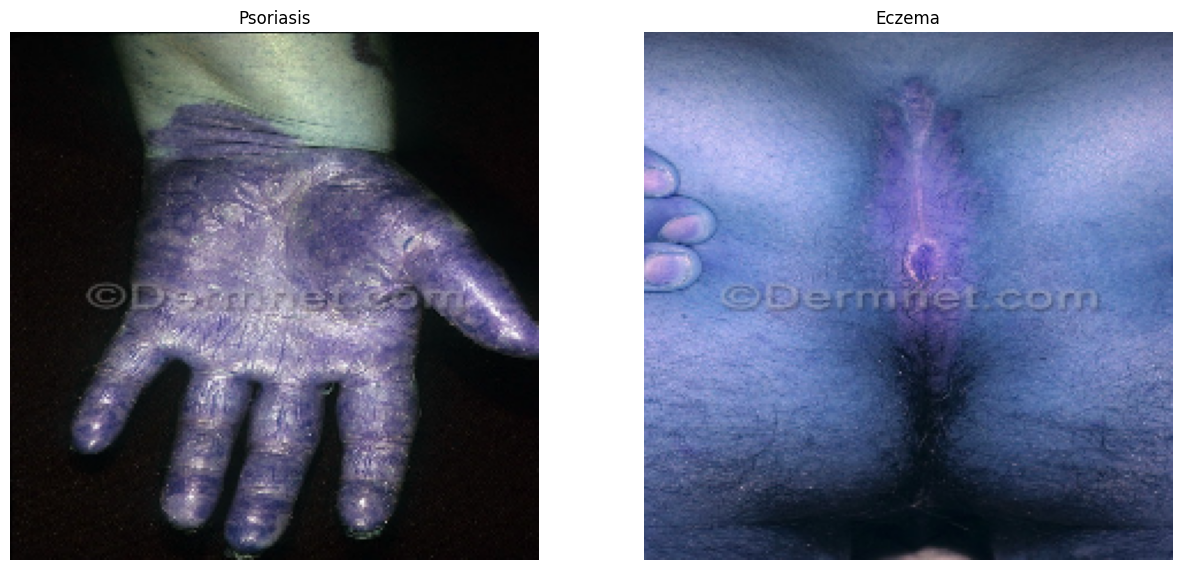

In [ ]:
plt.figure(figsize = (15,7))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(image_dataset.images[0])
plt.title(image_dataset.target_names[0])
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(image_dataset.images[1])
plt.title(image_dataset.target_names[1])
plt.show()

### <a id='toc1_1_4_'></a>[Train-Test Split](#toc0_)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset.data, image_dataset.target, test_size=0.1,random_state=42)

In [ ]:
print(f"X_train:{X_train.shape}")
print(f"X_test:{X_test.shape}")
print(f"y_train:{y_train.shape}")
print(f"y_test:{y_test.shape}")

X_train:(8631, 52900)
X_test:(959, 52900)
y_train:(8631,)
y_test:(959,)


### <a id='toc1_1_5_'></a>[Model Training](#toc0_)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
model_svm = Pipeline([
    ('pca', PCA(n_components=100)),
    ('svc', SVC(kernel='rbf'))
])
model_svm.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=100)), ('svc', SVC())])

In [ ]:
y_pred = model_svm.predict(X_test)

### <a id='toc1_1_6_'></a>[Model Evaluation](#toc0_)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import *

Classification report for - 
Pipeline(steps=[('pca', PCA(n_components=100)), ('svc', SVC())]):
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       347
           1       0.61      0.60      0.60       291
           2       0.66      0.66      0.66       321

    accuracy                           0.62       959
   macro avg       0.62      0.62      0.62       959
weighted avg       0.62      0.62      0.62       959


Cohen Kappa: 0.4259776536312849
Mathew Score: 0.4259797481100472


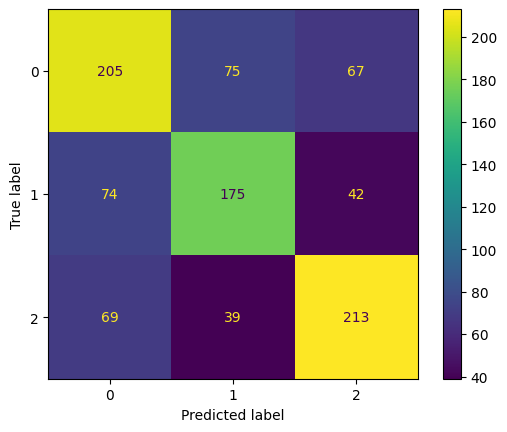

In [ ]:
print("Classification report for - \n{}:\n{}\n".format(model_svm, classification_report(y_test, y_pred)))
print(f"Cohen Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"Mathew Score: {matthews_corrcoef(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=model_svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_svm.classes_)
disp.plot()
plt.show()

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [ ]:
y_pred = rf.predict(X_test)

Classification report for - 
RandomForestClassifier(n_jobs=-1, random_state=42):
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       347
           1       0.90      0.85      0.87       291
           2       0.89      0.89      0.89       321

    accuracy                           0.88       959
   macro avg       0.88      0.88      0.88       959
weighted avg       0.88      0.88      0.88       959


Cohen Kappa: 0.8178113914555895
Mathew Score: 0.8182003417002165


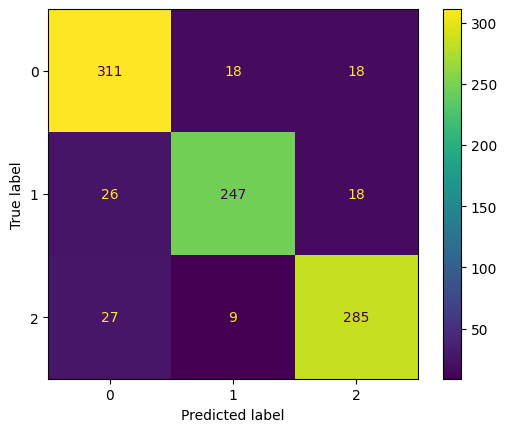

In [ ]:
print("Classification report for - \n{}:\n{}\n".format(rf, classification_report(y_test, y_pred)))
print(f"Cohen Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"Mathew Score: {matthews_corrcoef(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

### KNN

Classification report for - 
KNeighborsClassifier():
              precision    recall  f1-score   support

           0       0.47      0.77      0.58       347
           1       0.57      0.33      0.41       291
           2       0.71      0.49      0.58       321

    accuracy                           0.54       959
   macro avg       0.58      0.53      0.53       959
weighted avg       0.58      0.54      0.53       959


Cohen Kappa: 0.3007603590196717
Mathew Score: 0.3214262665276617


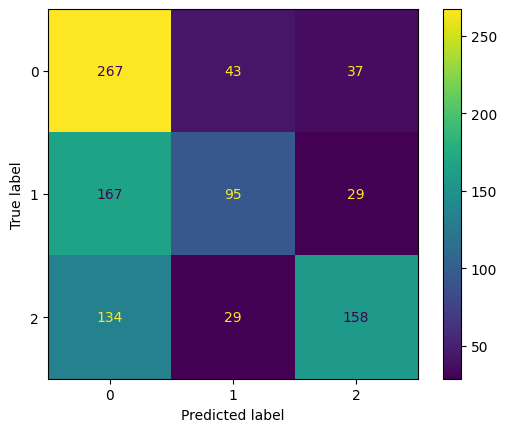

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(knn, classification_report(y_test, y_pred)))
print(f"Cohen Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"Mathew Score: {matthews_corrcoef(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()
plt.show()

### Decision Tree

Classification report for - 
DecisionTreeClassifier(random_state=42):
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       347
           1       0.86      0.87      0.87       291
           2       0.86      0.89      0.88       321

    accuracy                           0.87       959
   macro avg       0.87      0.87      0.87       959
weighted avg       0.87      0.87      0.87       959


Cohen Kappa: 0.8057118583145443
Mathew Score: 0.8059503125389988


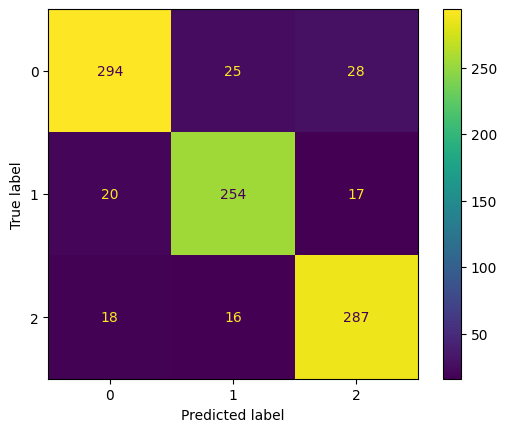

In [ ]:
from sklearn.tree import DecisionTreeClassifier
ds = DecisionTreeClassifier(random_state=42)
ds.fit(X_train, y_train)

y_pred = ds.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(ds, classification_report(y_test, y_pred)))
print(f"Cohen Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"Mathew Score: {matthews_corrcoef(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=ds.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=ds.classes_)
disp.plot()
plt.show()

Classification report for - 
ExtraTreesClassifier(random_state=42):
              precision    recall  f1-score   support

           0       0.85      0.88      0.87       347
           1       0.92      0.86      0.89       291
           2       0.88      0.90      0.89       321

    accuracy                           0.88       959
   macro avg       0.88      0.88      0.88       959
weighted avg       0.88      0.88      0.88       959


Cohen Kappa: 0.8193695582387202
Mathew Score: 0.8198320927560084


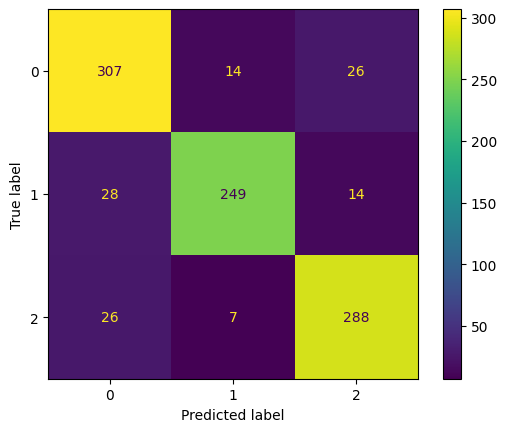

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
gbc = ExtraTreesClassifier(random_state=42)
gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

print("Classification report for - \n{}:\n{}\n".format(gbc, classification_report(y_test, y_pred)))
print(f"Cohen Kappa: {cohen_kappa_score(y_test, y_pred)}")
print(f"Mathew Score: {matthews_corrcoef(y_test, y_pred)}")
cm = confusion_matrix(y_test, y_pred, labels=gbc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=gbc.classes_)
disp.plot()
plt.show()